In [1]:
using Revise
using VCFTools
using MendelImpute
using GeneticVariation
using Random
using SparseArrays
using Plots

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /Users/biona001/.julia/packages/Revise/439di/src/Revise.jl:1108
┌ Info: Precompiling VCFTools [a620830f-fdd7-5ebc-8d26-3621ab35fbfe]
└ @ Base loading.jl:1273
┌ Info: Precompiling MendelImpute [e47305d1-6a61-5370-bc5d-77554d143183]
└ @ Base loading.jl:1273
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273


# Is initializing missing data causing problems?

In [2]:
# haplotype reference panels
H = convert_ht(Float32, "haplo_ref.vcf.gz", as_minorallele=false)
H = copy(H')

# import full genotype matrix
@time X = convert_gt(Float32, "target.vcf.gz"; as_minorallele = false)
X = copy(X')

# mask 10% entries
p, n = size(X)
Random.seed!(123)
missingprop = 0.1
Xm = copy(X)
Xm = ifelse.(rand(Float32, p, n) .< missingprop, missing, Xm)
Xm_original = copy(Xm)

  4.829174 seconds (73.04 M allocations: 6.269 GiB, 18.54% gc time)


35897×1000 Array{Union{Missing, Float32},2}:
 0.0       0.0       0.0       0.0       …  0.0       1.0       0.0     
 0.0       0.0       0.0       0.0          0.0       0.0       0.0     
 0.0       0.0       0.0        missing     0.0       1.0       0.0     
 0.0       0.0        missing  0.0           missing  0.0       0.0     
  missing  0.0       0.0        missing     0.0       1.0       0.0     
 0.0       0.0        missing  0.0       …  0.0       0.0       0.0     
 0.0       0.0       0.0       0.0          1.0       1.0       1.0     
 0.0       0.0       0.0       0.0           missing  0.0       0.0     
 0.0       0.0        missing  0.0          0.0       0.0       0.0     
 0.0        missing   missing  0.0           missing  0.0       1.0     
 2.0       2.0       2.0       2.0       …   missing  1.0        missing
 0.0        missing  0.0       1.0          0.0       0.0       0.0     
 0.0       0.0       0.0       0.0          1.0        missing  1.0     
 ⋮    

### Calculate error on observed entries only

In [14]:
width = 100
ph = @timed phase(Xm, H, width=width)
impute2!(Xm, H, ph[1])
missing_idx    = ismissing.(Xm_original)
total_missing  = sum(missing_idx)
actual_missing_values  = convert(Vector{Int64}, X[missing_idx])  #true values of missing entries
imputed_missing_values = convert(Vector{Int64}, Xm[missing_idx]) #imputed values of missing entries
error_rate = sum(actual_missing_values .!= imputed_missing_values) / total_missing
println("width $width: error = $error_rate, time = $(ph[2]) sec, memory = $(ph[3]/1e6) MB")
copyto!(Xm, Xm_original);

running window 2 / 358 now...
running window 3 / 358 now...
running window 4 / 358 now...
running window 5 / 358 now...
running window 6 / 358 now...
running window 7 / 358 now...
running window 8 / 358 now...
running window 9 / 358 now...
running window 10 / 358 now...
running window 11 / 358 now...
running window 12 / 358 now...
running window 13 / 358 now...
running window 14 / 358 now...
running window 15 / 358 now...
running window 16 / 358 now...
running window 17 / 358 now...
running window 18 / 358 now...
running window 19 / 358 now...
running window 20 / 358 now...
running window 21 / 358 now...
running window 22 / 358 now...
running window 23 / 358 now...
running window 24 / 358 now...
running window 25 / 358 now...
running window 26 / 358 now...
running window 27 / 358 now...
running window 28 / 358 now...
running window 29 / 358 now...
running window 30 / 358 now...
running window 31 / 358 now...
running window 32 / 358 now...
running window 33 / 358 now...
running window 3

### Error with different missing data initialization

In [10]:
# no MM iteration, impute using 0
width = 100
ph = @timed phase(Xm, H, width=width)
impute2!(Xm, H, ph[1])
missing_idx    = ismissing.(Xm_original)
total_missing  = sum(missing_idx)
actual_missing_values  = convert(Vector{Int64}, X[missing_idx])  #true values of missing entries
imputed_missing_values = convert(Vector{Int64}, Xm[missing_idx]) #imputed values of missing entries
error_rate = sum(actual_missing_values .!= imputed_missing_values) / total_missing
println("width $width: error = $error_rate, time = $(ph[2]) sec, memory = $(ph[3]/1e6) MB")
copyto!(Xm, Xm_original);

width 100: error = 0.011935604750856222, time = 5.257265347 sec, memory = 568.286366 MB


In [9]:
# no MM iteration, impute using mode
width = 100
ph = @timed phase(Xm, H, width=width)
impute2!(Xm, H, ph[1])
missing_idx    = ismissing.(Xm_original)
total_missing  = sum(missing_idx)
actual_missing_values  = convert(Vector{Int64}, X[missing_idx])  #true values of missing entries
imputed_missing_values = convert(Vector{Int64}, Xm[missing_idx]) #imputed values of missing entries
error_rate = sum(actual_missing_values .!= imputed_missing_values) / total_missing
println("width $width: error = $error_rate, time = $(ph[2]) sec, memory = $(ph[3]/1e6) MB")
copyto!(Xm, Xm_original);

width 100: error = 0.00946256927311187, time = 6.360458901 sec, memory = 592.227001 MB


In [4]:
# no MM iteration, impute using 2*(maf-freq)
width = 100
ph = @timed phase(Xm, H, width=width)
impute2!(Xm, H, ph[1])
missing_idx    = ismissing.(Xm_original)
total_missing  = sum(missing_idx)
actual_missing_values  = convert(Vector{Int64}, X[missing_idx])  #true values of missing entries
imputed_missing_values = convert(Vector{Int64}, Xm[missing_idx]) #imputed values of missing entries
error_rate = sum(actual_missing_values .!= imputed_missing_values) / total_missing
println("width $width: error = $error_rate, time = $(ph[2]) sec, memory = $(ph[3]/1e6) MB")
copyto!(Xm, Xm_original);

width 100: error = 0.0077932772856577305, time = 5.004080104 sec, memory = 530.762752 MB


In [23]:
# with MM iteration, impute using 2*(maf-freq)
width = 100
ph = @timed phase(Xm, H, width=width)
impute2!(Xm, H, ph[1])
missing_idx    = ismissing.(Xm_original)
total_missing  = sum(missing_idx)
actual_missing_values  = convert(Vector{Int64}, X[missing_idx])  #true values of missing entries
imputed_missing_values = convert(Vector{Int64}, Xm[missing_idx]) #imputed values of missing entries
error_rate = sum(actual_missing_values .!= imputed_missing_values) / total_missing
println("width $width: error = $error_rate, time = $(ph[2]) sec, memory = $(ph[3]/1e6) MB")
copyto!(Xm, Xm_original);

iter = 1, discrepancy = 831.8212, hapscore[1] = 0.3546333
iter = 2, discrepancy = 40.0, hapscore[1] = 0.0
iter = 3, discrepancy = 0.0, hapscore[1] = 0.0
iter = 1, discrepancy = 1230.5477, hapscore[1] = 13.209554
iter = 2, discrepancy = 16.0, hapscore[1] = 1.0
iter = 3, discrepancy = 0.0, hapscore[1] = 0.0
iter = 1, discrepancy = 713.6229, hapscore[1] = 2.2996888
iter = 2, discrepancy = 38.0, hapscore[1] = 0.0
iter = 3, discrepancy = 0.0, hapscore[1] = 0.0
iter = 1, discrepancy = 999.20557, hapscore[1] = 0.284981
iter = 2, discrepancy = 32.0, hapscore[1] = 0.0
iter = 3, discrepancy = 0.0, hapscore[1] = 0.0
iter = 1, discrepancy = 1189.5441, hapscore[1] = 0.2402973
iter = 2, discrepancy = 38.0, hapscore[1] = 0.0
iter = 3, discrepancy = 0.0, hapscore[1] = 0.0
iter = 1, discrepancy = 1076.7393, hapscore[1] = 1.2538524
iter = 2, discrepancy = 29.0, hapscore[1] = 0.0
iter = 3, discrepancy = 0.0, hapscore[1] = 0.0
iter = 1, discrepancy = 665.8039, hapscore[1] = 2.1607327
iter = 2, discrepancy

### Error when initializing missing data with true data

In [7]:
width = 100
ph = @timed phase(Xm, H, width=width, Xtrue=X)
impute2!(Xm, H, ph[1])
missing_idx    = ismissing.(Xm_original)
total_missing  = sum(missing_idx)
actual_missing_values  = convert(Vector{Int64}, X[missing_idx])  #true values of missing entries
imputed_missing_values = convert(Vector{Int64}, Xm[missing_idx]) #imputed values of missing entries
error_rate = sum(actual_missing_values .!= imputed_missing_values) / total_missing
println("width $width: error = $error_rate, time = $(ph[2]) sec, memory = $(ph[3]/1e6) MB")
copyto!(Xm, Xm_original);

width 100: error = 0.000518104134198158, time = 4.706200397 sec, memory = 537.406856 MB


In [5]:
width = 1200
ph = @timed phase(Xm, H, width=width, Xtrue=X)
impute2!(Xm, H, ph[1])
missing_idx    = ismissing.(Xm_original)
total_missing  = sum(missing_idx)
actual_missing_values  = convert(Vector{Int64}, X[missing_idx])  #true values of missing entries
imputed_missing_values = convert(Vector{Int64}, Xm[missing_idx]) #imputed values of missing entries
error_rate = sum(actual_missing_values .!= imputed_missing_values) / total_missing
println("width $width: error = $error_rate, time = $(ph[2]) sec, memory = $(ph[3]/1e6) MB")
println("total number of errors = ", sum(X .!= Xm))
mendel_disagreeing_entries = randn(size(X)) .* sparse(X .!= Xm)
copyto!(Xm, Xm_original);

width 1200: error = 0.0031865770661107557, time = 5.721392736 sec, memory = 115.615648 MB
total number of errors = 11446


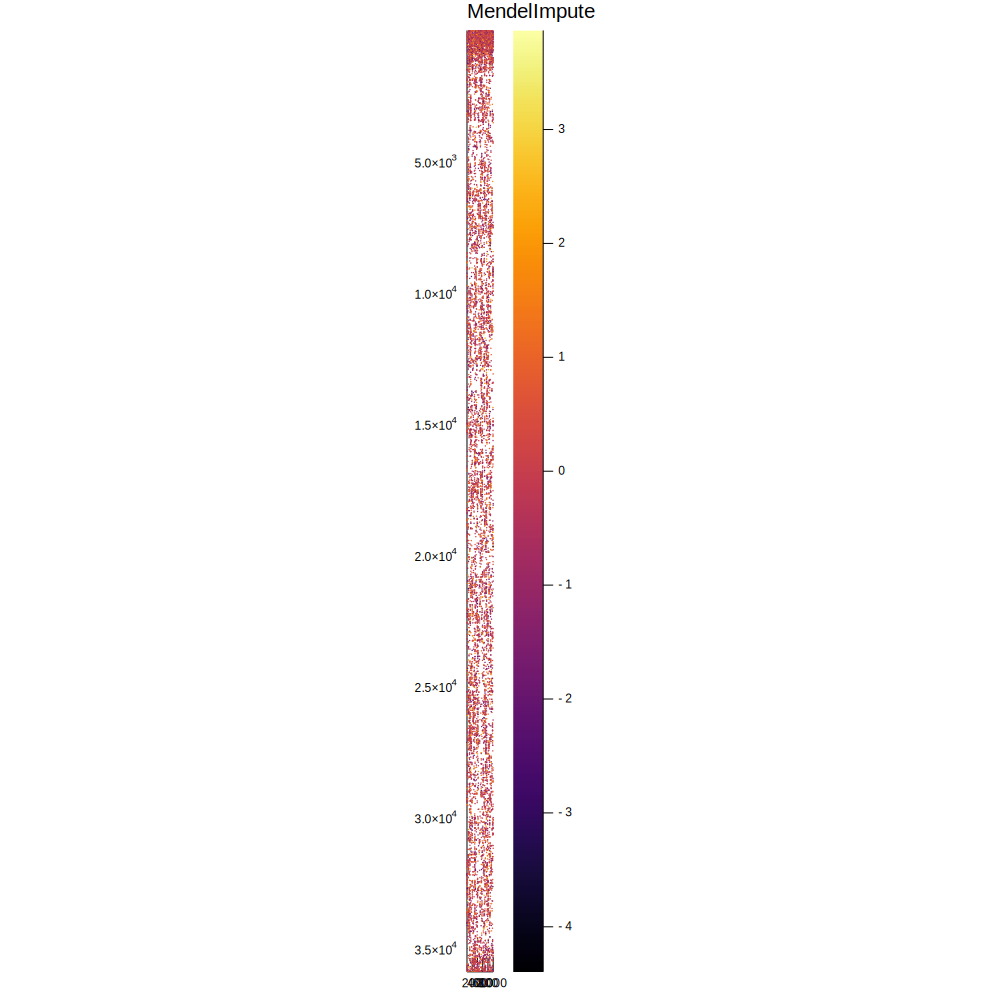

In [6]:
Plots.spy(mendel_disagreeing_entries, size=(1000,1000), title="MendelImpute", title_location=:left)

In [7]:
for i in 1:Int(ceil(size(X, 1) / width)) - 1
    println(count(!iszero, mendel_disagreeing_entries[(1 + width * (i - 1)):width * i, :]))
end

2009
408
360
194
238
414
345
240
366
372
275
239
323
255
389
251
218
309
345
280
302
392
425
287
291
314
348
385
324


# There exist numerous "optimal" haplotype pair in each window!

In [10]:
width = 100
ph = @timed phase(Xm, H, width=width)
impute2!(Xm, H, ph[1])
missing_idx    = ismissing.(Xm_original)
total_missing  = sum(missing_idx)
actual_missing_values  = convert(Vector{Int64}, X[missing_idx])  #true values of missing entries
imputed_missing_values = convert(Vector{Int64}, Xm[missing_idx]) #imputed values of missing entries
error_rate = sum(actual_missing_values .!= imputed_missing_values) / total_missing
println("width $width: error = $error_rate, time = $(ph[2]) sec, memory = $(ph[3]/1e6) MB")
copyto!(Xm, Xm_original);

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 3.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[4.0, 2.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0

In [11]:
width = 100
ph = @timed phase(Xm, H, width=width)
impute2!(Xm, H, ph[1])
missing_idx    = ismissing.(Xm_original)
total_missing  = sum(missing_idx)
actual_missing_values  = convert(Vector{Int64}, X[missing_idx])  #true values of missing entries
imputed_missing_values = convert(Vector{Int64}, Xm[missing_idx]) #imputed values of missing entries
error_rate = sum(actual_missing_values .!= imputed_missing_values) / total_missing
println("width $width: error = $error_rate, time = $(ph[2]) sec, memory = $(ph[3]/1e6) MB")
copyto!(Xm, Xm_original);

Tuple{Int64,Int64}[(5, 54)]
Tuple{Int64,Int64}[(23, 34)]
Tuple{Int64,Int64}[(10, 10)]
Tuple{Int64,Int64}[(11, 11)]
Tuple{Int64,Int64}[(10, 22)]
Tuple{Int64,Int64}[(9, 23)]
Tuple{Int64,Int64}[(21, 25)]
Tuple{Int64,Int64}[(21, 50)]
Tuple{Int64,Int64}[(23, 29), (23, 37)]
Tuple{Int64,Int64}[(22, 24)]
Tuple{Int64,Int64}[(3, 26)]
Tuple{Int64,Int64}[(5, 18)]
Tuple{Int64,Int64}[(29, 39)]
Tuple{Int64,Int64}[(55, 57)]
Tuple{Int64,Int64}[(34, 66)]
Tuple{Int64,Int64}[(29, 32)]
Tuple{Int64,Int64}[(2, 5)]
Tuple{Int64,Int64}[(1, 2), (17, 64), (39, 73)]
Tuple{Int64,Int64}[(4, 5)]
Tuple{Int64,Int64}[(4, 5)]
Tuple{Int64,Int64}[(5, 17)]
Tuple{Int64,Int64}[(17, 24)]
Tuple{Int64,Int64}[(20, 31)]
Tuple{Int64,Int64}[(13, 20)]
Tuple{Int64,Int64}[(11, 65)]
Tuple{Int64,Int64}[(19, 37)]
Tuple{Int64,Int64}[(21, 33)]
Tuple{Int64,Int64}[(33, 53)]
Tuple{Int64,Int64}[(52, 83)]
Tuple{Int64,Int64}[(32, 54)]
Tuple{Int64,Int64}[(10, 30)]
Tuple{Int64,Int64}[(1, 8)]
Tuple{Int64,Int64}[(13, 27)]
Tuple{Int64,Int64}[(7, 34)]


In [17]:
width = 100
ph = @timed phase(Xm, H, width=width)
impute2!(Xm, H, ph[1])
missing_idx    = ismissing.(Xm_original)
total_missing  = sum(missing_idx)
actual_missing_values  = convert(Vector{Int64}, X[missing_idx])  #true values of missing entries
imputed_missing_values = convert(Vector{Int64}, Xm[missing_idx]) #imputed values of missing entries
error_rate = sum(actual_missing_values .!= imputed_missing_values) / total_missing
println("width $width: error = $error_rate, time = $(ph[2]) sec, memory = $(ph[3]/1e6) MB")
copyto!(Xm, Xm_original);

width 100: error = 0.0077932772856577305, time = 8.039143327 sec, memory = 560.822743 MB
